In [144]:
# import datasets 
import numpy as np
import os
import time
import torch
import tensorflow as tf
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
# import torchvision
# import torchtext
from torch.utils.data.sampler import SubsetRandomSampler
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from langdetect import detect_langs
from torch.nn.utils.rnn import pad_sequence
from pandarallel import pandarallel 
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from tqdm.notebook import tqdm
import pickle

if torch.cuda.is_available():  
  use_cuda = True
else:  
  use_cuda = False

In [2]:
use_cuda

True

# Data Loading

In [4]:
# loading GLOVE embeddings
# GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words

In [3]:
#load the npy file and the txt file
tmp_np_arr = np.load('hate_speech_spliced.npy', allow_pickle=True)
#load the column names to a list
label_names = list(np.loadtxt('hate_speech_spliced_col_names.txt', dtype=str))
#convert to pandas dataframe
df_spliced = pd.DataFrame(tmp_np_arr, columns=label_names)


In [4]:
#display the first 5 rows
df_spliced.head()

,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,text
0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,Yes indeed. She sort of reminds me of the elde...
1,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,The trans women reading this tweet right now i...
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,Question: These 4 broads who criticize America...
3,0.75,0.5,0.25,0.5,0.0,0.0,0.0,0.75,It is about time for all illegals to go back t...
4,1.0,1.0,1.0,1.0,1.0,1.0,0.25,0.75,For starters bend over the one in pink and kic...


In [5]:
tweets = df_spliced.iloc[:,-1:]

In [6]:
labels = df_spliced.iloc[:,:-1]

In [7]:
labels = labels.to_numpy()

In [8]:
label_names = list(df_spliced.iloc[:,:-1].columns)

In [9]:
label_names

['respect',
 'insult',
 'humiliate',
 'status',
 'dehumanize',
 'violence',
 'genocide',
 'attack_defend']

In [10]:
train_size = int(0.7*len(df_spliced))
val_size = int((len(df_spliced) - train_size)/2)
test_size = len(df_spliced) - train_size - val_size

In [11]:
train_size

93867

In [12]:
val_size

20115

In [13]:
test_size

20115

In [11]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [17]:
# def get_tweet_words(glove_vector):
#     train, valid, test = [], [], []
#     for index, row in df_spliced.iterrows():
#         try:
#             tweet = row[-1]
#             idxs = [glove_vector.stoi[w]        # lookup the index of word
#                     for w in split_tweet(tweet)
#                     if w in glove_vector.stoi] # keep words that has an embedding
#             if not idxs: # ignore tweets without any word with an embedding
#                 print(tweet)
#                 continue
#             idxs = torch.tensor(idxs) # convert list to pytorch tensor
#             label = np.array(row[:-1].values).astype(np.float32) 
#             label = torch.tensor(label) #storing label information to tensor
#             #adding tweet to corresponding train/val/test set
#             if index < train_size:
#                 train.append((idxs, label))
#             elif index < train_size+val_size:
#                 valid.append((idxs, label))
#             else:
#                 test.append((idxs, label))
#         except:
#             print("Error at index: ", index)
#             continue
#     return train, valid, test


# train, valid, test = get_tweet_words(glove_vector=GLOVE)

In [12]:
#creating vocab from df_spliced
def build_vocab():
    vocab = []
    for index, row in df_spliced.iterrows():
        tweet = row[-1]
        for word in split_tweet(tweet):
            if word not in vocab:
                vocab.append(word)
    return vocab

#create vocab to index mapping
def create_vocab_index_mapping(vocab):
    vocab_index_mapping = {}
    index_to_word = {}
    for index, word in enumerate(vocab):
        vocab_index_mapping[word] = index
        index_to_word[index] = word
    return vocab_index_mapping, index_to_word


def tokenize_words(word_to_index, index_to_word):
    train, valid, test = [], [], []
    for index, row in df_spliced.iterrows():
        # try to create a list of indices for each tweet
        try:
            tweet = row[-1]
            idxs = [word_to_index[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in word_to_index] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                print(tweet)
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = np.array(row[:-1].values).astype(np.float32) 
            label = torch.tensor(label) #storing label information to tensor
            #adding tweet to corresponding train/val/test set
            if index < train_size:
                train.append((idxs, label))
            elif index < train_size+val_size:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
        except:
            print("Error at index: ", index)
            continue
        
    return train, valid, test

# vocab = build_vocab()
# word_to_index, index_to_word = create_vocab_index_mapping(vocab)
# tokenize_words(vocab, word_to_index, index_to_word)

# train, valid, test = tokenize_words(word_to_index, index_to_word)

In [13]:
vocab = build_vocab()
word_to_index, index_to_word = create_vocab_index_mapping(vocab) #this will take around 2 minutes

In [147]:
#save mapping to pickle file
with open('word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('index_to_word.pkl', 'wb') as f:
    pickle.dump(index_to_word, f)

In [14]:
len(vocab)

59693

In [15]:
train, valid, test = tokenize_words(word_to_index, index_to_word)

In [16]:
len(test)

20115

In [17]:
from torch import nn
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad
  

# Helpers

In [18]:
###############################################################################
# For Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path


###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Models

In [138]:
""" EPAI Class Models
This file contains the class objects for RNN, BiRNN, LSTM, BiLSTM and GRU.
"""
# import gensim.downloader
import torch
from torch import nn
# import torchtext

# global variables
# GLOVE = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000)  # use 10k most common words
# WORD2VEC = gensim.downloader.load("word2vec-google-news-300")


class NETWORK(nn.Module):
    """
    The class object for the model network.
    Attributes:
    emb: the type of embedding
    hidden_size: the number of layers
    nn: the actual neural network
    fc: the activation layer
    """

    # param: type:str
    # param: vocab_size:int
    # param: embedding_dim:int
    # param: hidden_dim:int
    # param: output_dim:int
    # param: n_layers:int
    # param: bidirectional:bool
    # param: dropout:float
    # return: void
    # initializes the neural network with the given parameters
    def __init__(self, type, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.type = type
        if self.type == "RNN":
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.type == "GRU":
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif self.type == "LSTM":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        else:
            raise Exception("Invalid RNN type")
        self.layers = n_layers
        self.fc = nn.Linear(hidden_dim*n_layers, 256)
        # self.fc1 = nn.Linear(512, 256)
        # self.fc2 = nn.Linear(256, 128)
        # self.fc3 = nn.Linear(128, 64)
        # self.fc4 = nn.Linear(64, 32)
        # self.fc5 = nn.Linear(32, 16)
        # self.fc6 = nn.Linear(16, output_dim)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, output_dim)
        # self.fc_out = nn.Linear(hidden_dim*(2 if bidirectional else 1), output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    # param: text:torch.Tensor
    # return: torch.Tensor
    # forward pass of the neural network
    def forward(self, text):
        # embedded = self.dropout(self.embedding(text))
        embedded = self.embedding(text)
        if self.type == "LSTM":
            output, (hidden, cell) = self.rnn(embedded)
        elif self.type == "GRU":
            output, hidden = self.rnn(embedded)
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        if self.layers == 1:
           hidden = self.dropout(hidden[0:,:])
        else:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        hidden = self.relu(self.fc(hidden))
        hidden = self.relu(self.fc1(hidden))
        # hidden = self.relu(self.fc2(hidden))
        # hidden = self.relu(self.fc3(hidden))
        # hidden = self.relu(self.fc4(hidden))
        # hidden = self.relu(self.fc5(hidden))
        # return self.fc6(hidden)
        return self.fc2(hidden)
        # return self.fc_out(hidden) #DO NOT apply relu on the last layer; sigmoid included in logit loss


# Training

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs= inputs.cuda()
          labels = labels.cuda()
          net = net.cuda()
        outputs = net(inputs)
        loss_func = nn.BCELoss()
        loss = loss_func(outputs, labels.float())
        loss.backward()
    return_loss = float(loss)
    return return_loss
   

def get_f1_accuracy(label, pred):
    pred = pred.detach().numpy()
    label = label.detach().numpy()
    pred = sigmoid(pred)
    pred = np.where(pred >= 0.5, 1, 0)
    label = np.where(label >= 0.5, 1, 0)
    # pred = np.where(pred >=0.6, 1, 0)
    # label = np.where(label >= 0.6, 1, 0)
    return f1_score(label, pred, average='macro', zero_division=0)


def train_net(net, device, batch_size=150, learning_rate=0.005, epochs=6):
        
    #initiate loaders according to batch size
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    #defind sigmoid function
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_iters, val_iters, train_loss, valid_loss, train_acc, val_acc = [], [], [], [], [], []
    n = 0 # the number of training iterations
    m = 0 # the number of validation iterations
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    # create status bar
    pbar = tqdm(total = len(train_loader), desc = "Training")
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} of {epochs}')
        pbar.reset()
        for text, labels in iter(train_loader):
            text = text.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = net(text)
            # train_acc.append(get_f1_accuracy(labels.cpu(), sigmoid(output.cpu().detach())))
            train_acc.append(get_f1_accuracy(labels.cpu(), output.cpu()))
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            #save training information
            train_iters.append(n)
            train_loss.append(float(loss)) 
            # calculate for validation loss
            
            n += 1

            # update status bar
            if n%50 == 0:
                pbar.set_postfix({'loss': float(loss), 'train_acc': train_acc[-1]})
                pbar.update(50)
                # print(sigmoid(output.cpu().detach().numpy()))

        # print(("Epoch {}: loss: {}, Training Accuracy: {}, Validation Accuracy: {}").format(
        #     epoch + 1, train_loss[epoch], train_acc[epoch], val_acc[epoch]
        # ))
        print("Validating...")
        # create loop for calculating for validation loss
        for text, labels in iter(valid_loader):
            text = text.to(device)
            labels = labels.to(device)
            val_pred = net(text)
            val_acc.append(get_f1_accuracy(labels.cpu(), val_pred.cpu()))
            val_loss = criterion(val_pred, labels)
            val_loss.backward()
            valid_loss.append(float(val_loss))

            val_iters.append(m)
            m += 1

        print(("Epoch {}: loss: {}, Training Accuracy: {} | Validation Accuracy : {}").format(
            epoch + 1, train_loss[epoch], train_acc[epoch], val_acc[epoch]
        ))

    # plotting; using spaghetti code for now since csv slows down training time
    print("Plotting...")
    plt.title("Loss Curve")
    plt.plot(train_iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(train_iters, train_acc, label="Train")
    # plt.plot(val_iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    plt.title("Validation Curve")
    plt.plot(val_iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.show()


    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))


In [139]:
NETWORK_TYPE = 'GRU' #specify the specific network type
INPUT_DIM=int(len(vocab)) #size of the vocabulary (number of words, arbitrary, but 10k is a good number)
# EMBEDDING_DIM = 8 #size of the word embeddings
EMBEDDING_DIM = 256
# HIDDEN_DIM = 8 #size of the hidden layer
HIDDEN_DIM = 100
OUTPUT_DIM = 8 #size of the output layer. Fixed to 8 for this project
N_LAYERS = 2 #number of stacked RNN type layers. Please note that this is not the number of layers in the network. Only use 1 or 2 or else the network becomes too complex
BIDIRECTIONAL = True #whether to use a bidirectional network
DROPOUT = 0.35 
LEARNING_RATE = 0.00075 #learning rate for the optimizer
# LEARNING_RATE = 0.001
EPOCHS = 5 #number of epochs to train the network
BATCH_SIZE = 512 #size of the batches, which is the number of samples to be propagated through the network

#activate GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)

#initialize the network
model = NETWORK(NETWORK_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
model.to(device)

using device:  cuda


NETWORK(
  (embedding): Embedding(59693, 256)
  (rnn): GRU(256, 100, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (fc): Linear(in_features=200, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.35, inplace=False)
)

Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch 1 of 5
Validating...
Epoch 1: loss: 0.6953493356704712, Training Accuracy: 0.38897505025377593 | Validation Accuracy : 0.8785741839566208
Epoch 2 of 5
Validating...
Epoch 2: loss: 0.6886125802993774, Training Accuracy: 0.38510879849120216 | Validation Accuracy : 0.8757578381747327
Epoch 3 of 5
Validating...
Epoch 3: loss: 0.6834897398948669, Training Accuracy: 0.4116407733234785 | Validation Accuracy : 0.8869889083454989
Epoch 4 of 5
Validating...
Epoch 4: loss: 0.6778548955917358, Training Accuracy: 0.42240287972388557 | Validation Accuracy : 0.8709794290303139
Epoch 5 of 5
Validating...
Epoch 5: loss: 0.6720025539398193, Training Accuracy: 0.4549891200850126 | Validation Accuracy : 0.8846929846383496
Plotting...


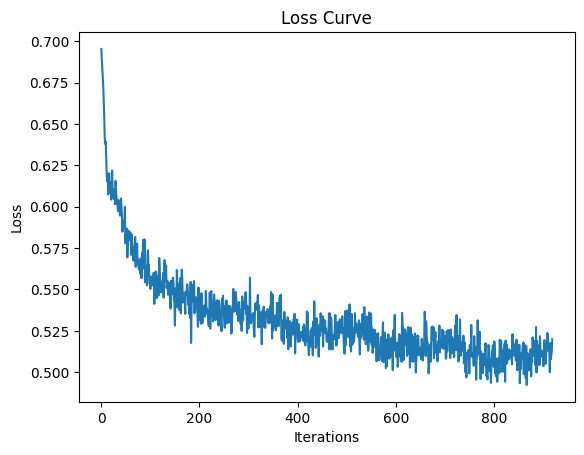

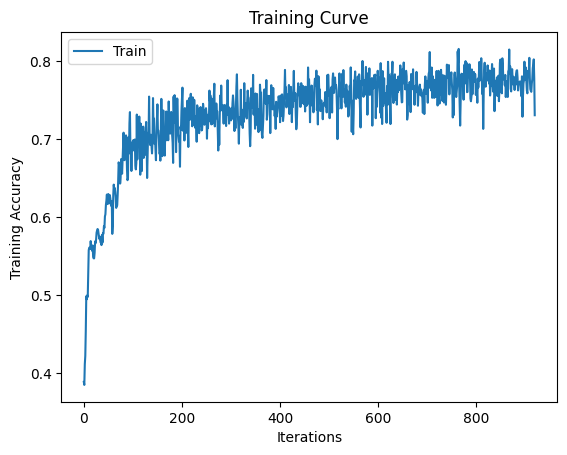

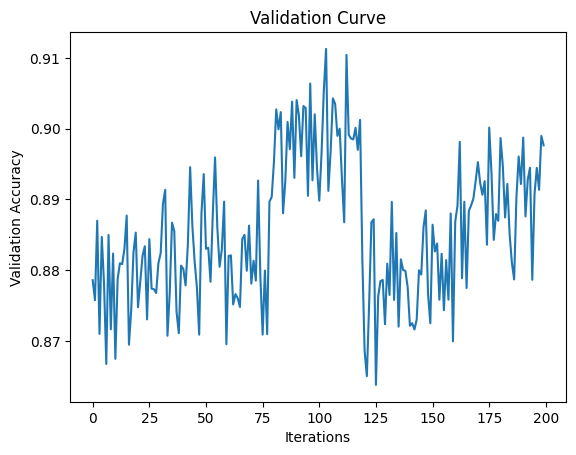

Total time elapsed: 71.17 seconds


In [129]:
#train the network
train_net(model, device, BATCH_SIZE, LEARNING_RATE, EPOCHS)

In [71]:
#testing the network on the test set
def test_net(net, device, batch_size=100):
    #initiate loaders according to batch size
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    criterion = nn.BCEWithLogitsLoss()
    test_loss = 0
    test_acc = 0
    net.eval()
    with torch.no_grad():
        for text, labels in iter(test_loader):
            text = text.to(device)
            labels = labels.to(device)
            output = net(text)
            test_acc += get_f1_accuracy(labels.cpu(), output.cpu())
            loss = criterion(output, labels.squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader):.3f} | Test Acc: {test_acc/len(test_loader):.2f}')

In [130]:
test_net(model, device)

Test Loss: 0.475 | Test Acc: 0.60


In [86]:
#export the model to a .pth file
torch.save(model.state_dict(), 'model.pth')

In [131]:
#testing the network on a single sentence
def predict_sentiment(net, sentence):
    idxs = [word_to_index[w]        # lookup the index of word
                    for w in split_tweet(sentence)
                    if w in word_to_index] # keep words that has an embedding
    print(idxs)
    tensor = torch.tensor(idxs).to(device)  # convert sentence to tensor
    tensor = tensor.unsqueeze(0)  # change shape from [n_words] to [n_words, 1]
    output = net(tensor)  # get predictions from network
    #convert to probabilities
    output = torch.sigmoid(output)
    #average the predictions
    # output = torch.mean(output)    
    
    print(output)

#predict sentiment of a sentence
sentence = "you basically need to do the same as in tensorflow. That is, when you store a network, only the parameters"
predict_sentiment(model, sentence)

[144, 1292, 764, 27, 141, 8, 299, 301, 14, 2, 11, 51, 59, 134, 144, 7736, 104, 10199, 59, 373, 8]
tensor([[0.5681, 0.5547, 0.4746, 0.5587, 0.4016, 0.2396, 0.1984, 0.5760]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


In [143]:
# Loading saved .pth model
saved_model = model
saved_model.load_state_dict(torch.load('model.pth'))
saved_model.eval()

input_data = "I respect your take, but perhaps you didn't need to phrase it so harshly"
predict_sentiment(saved_model, input_data)

[23, 1883, 512, 750, 59, 440, 1935, 144, 1911, 764, 27, 9666, 42, 123, 32805]
tensor([[0.3730, 0.3277, 0.3139, 0.5118, 0.2775, 0.1802, 0.1358, 0.4132]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
